<center><font size = "10"> Multicompartmental Neuron Model: <center>
<center><font size = "8"> Cable Theory <center>
<center><font size = "8">Tutorial 03: Load a Real Morphology<center>

<font color='blue'><font size='3'>In this tutorial you will see how to load and perform experiments on a real morphology, using the approach of the cable theory shown in the lecture.
    
    
<font size='3'><font color='blue'>If you haven't done so for the previous tutorials, we encorage you to review the concepts of __cable theory__ in the lecture or/and in [here](https://en.wikipedia.org/wiki/Cable_theory) as well as the concepts of __passive and active electrical properties__ of a neuron in [here](http://www.scholarpedia.org/article/Neuron#:~:text=themes%20of%20concern.-,Passive%20electrical%20properties,cytoplasm%20and%20the%20extracellular%20milieu.)

## 1. Load and instantiate a real morphology

In [1]:
%matplotlib inline

from neuron import h
import matplotlib.pyplot as plt
import numpy as np
import math as m
import neurom as nm
from neurom import view
from hoc2swc import neuron2swc

--No graphics will be displayed.


In [2]:
class NEURON:
    def __init__(self):
        self.build_morphology()
        self.define_biophysics()

    def build_morphology(self):
        """
        Loads a 3D morphology of the neuron
        """
        # Load hoc routines to import 3D morphologies
        h.load_file("stdlib.hoc")
        h.load_file("import3d.hoc")
        # cell = h.Import3d_SWC_read() # We have a .swc morphology file
        cell = h.Import3d_Neurolucida3()

        # Read the file and creates automatically section.connect(parent) statements
        cell.input("dend-C060114A2_axon-C060110A5.asc")

        # Instantiate morphology for simulation and
        # execute the connect statements and loads the cell into h scope
        self.importedcell = h.Import3d_GUI(cell, 0)
        self.importedcell.instantiate(None)

        # Create python lists from the morphology with the different sections: soma, dend, apic and axon
        self.somatic = []
        self.dendritic = []
        self.apical = []
        self.axonal = []
        self.all = []
        for sec in h.allsec():
            if "soma" in sec.name():
                self.somatic.append(sec)
            if "dend" in sec.name():
                self.dendritic.append(sec)
            if "apic" in sec.name():
                self.apical.append(sec)
            if "axon" in sec.name():
                self.axonal.append(sec)

    def define_biophysics(self):
        """
        Distributes passive mechanisms and hh active prop on the soma and dendrites
        """
        # Define passive properties for all sections
        for sec in h.allsec():
            sec.insert("pas")
            sec.nseg = 1
            for seg in sec:
                seg.pas.g = 0.0003  # Conductance of the leak channels (in S/cm2)
                seg.pas.e = -70

        # Define active properties for soma, dendrite, apical dendrite and axon
        for sec in self.somatic:
            # insert hh
            sec.insert("hh")
            sec.Ra = 1
            sec.nseg = 1
            for seg in sec:
                seg.hh.gkbar = 0.1  # Maximal conductance of the potassium channels
                seg.hh.gnabar = 0.4  # Maximal conductance of the sodium channels

        for sec in self.dendritic:
            # insert hh
            sec.insert("hh")
            sec.Ra = 300
            sec.nseg = 1
            for seg in sec:
                seg.hh.gkbar = 0.1  # Maximal conductance of the potassium channels
                seg.hh.gnabar = 0.4  # Maximal conductance of the sodium channels

        for sec in self.apical:
            # insert hh
            sec.insert("hh")
            sec.Ra = 400
            sec.nseg = 1
            for seg in sec:
                seg.hh.gkbar = 0.1  # Maximal conductance of the potassium channels
                seg.hh.gnabar = 0.4  # Maximal conductance of the sodium channels

        for sec in self.axonal:
            # insert hh
            sec.insert("hh")
            sec.Ra = 100
            sec.nseg = 1
            for seg in sec:
                seg.hh.gkbar = 0.1  # Maximal conductance of the potassium channels
                seg.hh.gnabar = 0.4  # Maximal conductance of the sodium channels

In [3]:
Cell = NEURON()


17519 lines read


## 2. Stimulates and record the soma

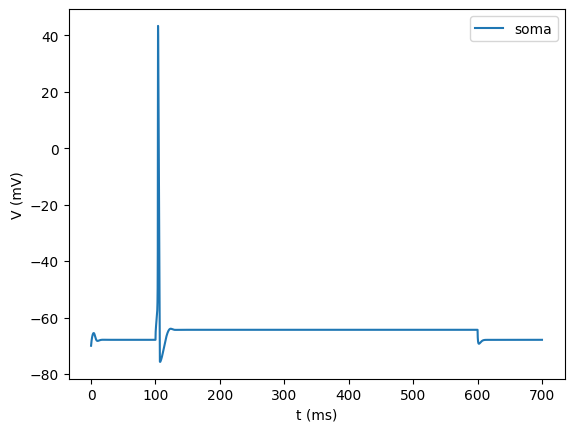

In [4]:
# Inject a current step into the soma

# Place a stimulation electrode in the middle of the soma
stim = h.IClamp(Cell.somatic[0](0.5))
stim.delay = 100  # stim delay (ms)
stim.amp = 0.5  # stim amplitude (pA)
stim.dur = 500  # stim duration (ms)

# Initialize NEURON vectors to record time, voltage and current
# time vector
rec_t = h.Vector()
rec_t.record(h._ref_t)
# membrame potential vector
rec_v_soma = h.Vector()
rec_v_soma.record(Cell.somatic[0](0.5)._ref_v)
# current
rec_i = h.Vector()
rec_i.record(stim._ref_i)

# Initialize and run a simulation
h.load_file("stdrun.hoc")
h.finitialize(-70)
h.continuerun(700)

plt.figure()
plt.ylabel("V (mV)")
plt.xlabel("t (ms)")
plt.plot(rec_t, rec_v_soma, label="soma")
plt.legend()

## 3. Back propagating action potential: stimulates soma and record at soma and dendrites
### Dendritic voltage attenuation

In [5]:
# Global containers for objects
simulations_records = []  # stimulations
voltage_records = []  # voltage recordings
current_records = []  # current recordings


def reset():
    """Convenience functions for setting up stimulation, recording and simulation"""
    del simulations_records[:]
    del voltage_records[:]
    del current_records[:]


def iclamp(location, delay=100, amplitude=0.1, duration=500):
    """"Inject a current step with parameters at location"""
    stim = h.IClamp(location)  # Place a stimulation electrode at location
    stim.delay = delay  # stim delay (ms)
    stim.amp = amplitude  # stim amplitude (pA)
    stim.dur = duration  # stim ducurrent_recordsration (ms)
    simulations_records.append({"stim": stim, "loc": str(location)})


def record_voltage(location):
    """Setup recording of voltage at location"""
    vec = h.Vector()
    vec.record(location._ref_v)  # record voltage at location
    voltage_records.append({"vec": vec, "loc": str(location)})


def record_current(stimulation_dict):
    """Setup recording of stimulation current"""
    vec = h.Vector()
    vec.record(stimulation_dict["stim"]._ref_i)  # record stimulation current
    current_records.append({"vec": vec, "loc": stimulation_dict["loc"]})


def init_run(v_i, t_stop):
    """Initialize and run a simulation"""
    # Record time
    rec_t = h.Vector()
    rec_t.record(h._ref_t)
    # Record current for all stimuli
    for stimulation_dict in simulations_records:
        record_current(stimulation_dict)
    # Setup simulation and run
    h.load_file("stdrun.hoc")
    h.finitialize(v_i)  # initial voltage
    h.continuerun(t_stop)  # final time
    return rec_t


def tvi_plots(
    t, voltage_records=[], current_records=[], vmax=40, imax=0.5, legendv=True):
    """Plot current and voltage for all stims and recordings"""
    plt.figure()
    plt.title("currents")
    plt.ylim((-0.01, imax))
    plt.xlabel("t (ms)")
    plt.ylabel("I (pA)")
    for idict in current_records:
        plt.plot(t, idict["vec"], label=idict["loc"])
    if legendv:
        plt.legend(loc=1)

    plt.figure()
    plt.title("voltages")
    plt.ylim((-71, vmax))
    plt.ylabel("V (mV)")
    plt.xlabel("t (ms)")
    for vdict in voltage_records:
        plt.plot(t, vdict["vec"], label=vdict["loc"])
    plt.legend(loc=1)


def plot_morphology(fname="cell_01"):
    fname = "{}.swc".format(fname)
    h.define_shape()
    h.topology()
    neuron2swc(fname, swap_yz=False)
    neuron1 = nm.load_morphology(fname)
    view.plot_morph(neuron1)

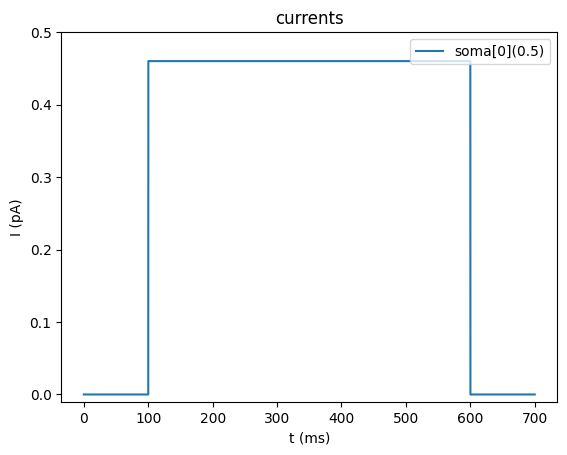

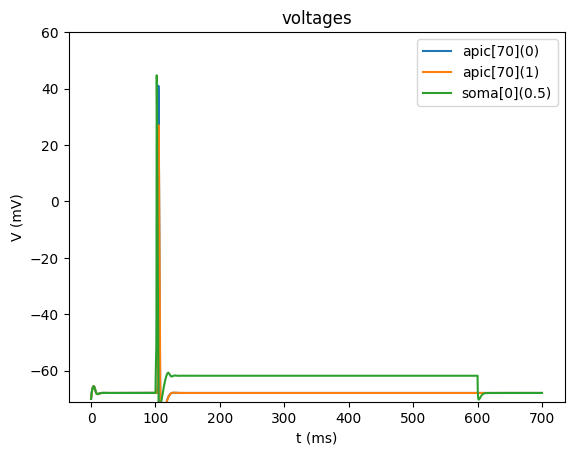

In [6]:
reset()

# Scan at different locations with different delays
locations = np.linspace(0, 1, 2)

# Setup stimulations and recordings
iclamp(Cell.somatic[0](0.5), amplitude=0.46)
for p in locations:
    record_voltage(Cell.apical[70](p))
record_voltage(Cell.somatic[0](0.5))

# Simulate and plot
v_init = -70
t_stop = 700
tvi_plots(init_run(v_init, t_stop), voltage_records, current_records, vmax=60)

# 4. Dendritic signal integration in the soma

<font size="3">Here we'll sequentially stimulate all dendrites, with some temporal overlap, which sometimes will lead to APs at the soma.

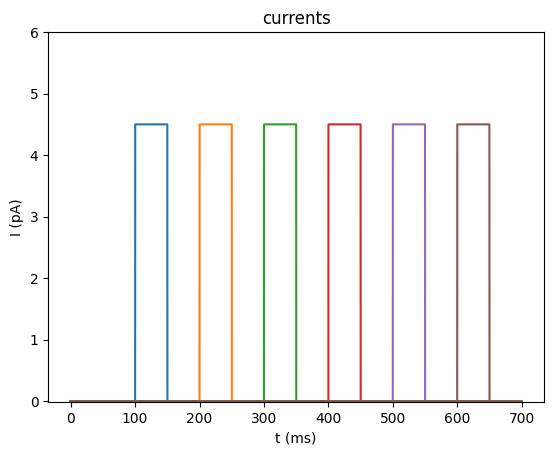

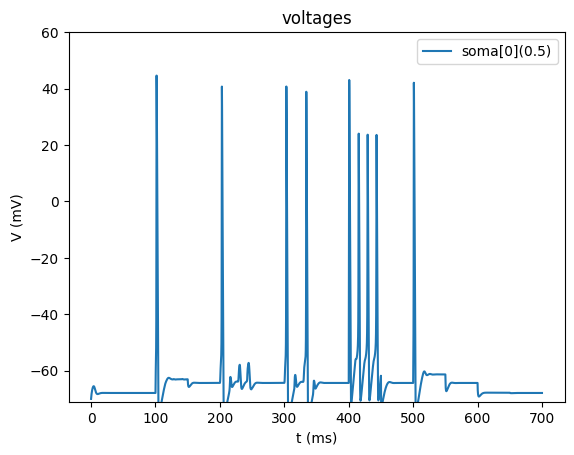

In [7]:
reset()

dendrite_list = Cell.dendritic + Cell.apical

# Setup stimulations and recordings
for idx, dendrites in enumerate(dendrite_list):
    iclamp(dendrites(0.5), amplitude=4.5, delay=100 + idx * 100, duration=50)
record_voltage(Cell.somatic[0](0.5))

# Simulate and plot
v_init = -70
t_stop = 700
tvi_plots(
    init_run(v_init, t_stop),
    voltage_records,
    current_records,
    vmax=60,
    imax=6,
    legendv=False,
)